# Baseline CNN UNet model
Course: Applied Deep Learning, TU Wien <br>
Date: 16/12 2025<br>
Author: Helena Cooper<br>
Matrikel: 12505729<br>

This models uses the following: <br>
- Batch size: 8
- Optimiser: Adam
- Learning rate: 1e-4
- Loss: L1
- Epochs: 5

## Imports

In [1]:
import time
import glob
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr_metric

## Helper functions

In [2]:
class CachedDataset(Dataset):
    def __init__(self, file_list, upscale_factor=4):
        self.upscale_factor = upscale_factor
        
        # 1. Define Transforms
        self.hr_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        
        self.lr_transform = transforms.Compose([
            transforms.Resize((256 // upscale_factor, 256 // upscale_factor)),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

        # 2. Pre-load ALL images into RAM now
        print(f"⏳ Caching {len(file_list)} images to RAM... this takes a moment but speeds up training huge!")
        self.data = []
        for img_path in tqdm(file_list):
            try:
                # Open and convert once
                image = Image.open(img_path).convert("RGB")
                
                # Apply transforms immediately and store TENSORS, not file paths
                hr_tensor = self.hr_transform(image)
                lr_tensor = self.lr_transform(image)
                
                self.data.append((lr_tensor, hr_tensor))
            except:
                pass # Skip broken images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 3. Super fast retrieval (no disk I/O, no resizing!)
        return self.data[idx]

In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, file_list, upscale_factor=4):
        self.file_list = file_list
        self.upscale_factor = upscale_factor
        
        self.hr_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.Resize((256 // upscale_factor, 256 // upscale_factor)),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")
        hr = self.hr_transform(image)
        lr = self.lr_transform(image)
        return lr, hr


In [4]:
def visualize_sample(model, loader, device, num_samples=3):
    model.eval() # Set model to evaluation mode
    
    # Get a single batch
    with torch.no_grad():
        low_res, high_res = next(iter(loader))
        low_res = low_res.to(device)
        
        # Get model prediction
        outputs = model(low_res)
        
    # Move images to CPU and numpy for plotting
    # We clip values to [0, 1] to avoid display errors with matplotlib
    low_res = low_res.cpu().permute(0, 2, 3, 1).numpy().clip(0, 1)
    outputs = outputs.cpu().permute(0, 2, 3, 1).numpy().clip(0, 1)
    high_res = high_res.cpu().permute(0, 2, 3, 1).numpy().clip(0, 1)

    plt.figure(figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # Plot Low Res (Input)
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(low_res[i])
        plt.title("Input (Blurry)")
        plt.axis("off")

        # Plot Prediction (Output)
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(outputs[i])
        plt.title("Model Prediction")
        plt.axis("off")

        # Plot High Res (Target)
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(high_res[i])
        plt.title("Ground Truth (Sharp)")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show() # If running in a script, you might want plt.savefig(f"epoch_results.png")
    
    model.train() # IMPORTANT: Switch back to training mode!

In [5]:
class CharbonnierLoss(nn.Module):
    """L1 Loss variant that is differentiable and MPS-safe."""
    def __init__(self, eps=1e-6):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        loss = torch.sqrt(diff * diff + self.eps)
        return torch.mean(loss)

In [6]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        # 1. Load VGG19 pretrained on ImageNet
        # We use the 'features' part of the network, not the classifier
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        
        # 2. Slice specific layers to capture different "scales" of details
        # Block 1 (Texture), Block 2 (Shapes), Block 3 (Structure)
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        
        for x in range(2):
            self.slice1.add_module(str(x), vgg[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg[x])
            
        # 3. Freeze VGG weights (We do NOT train this!)
        for param in self.parameters():
            param.requires_grad = False
            
        # 4. Normalization for VGG (ImageNet stats)
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, pred, target):
        # Normalize inputs
        pred = (pred - self.mean) / self.std
        target = (target - self.mean) / self.std
        
        # Extract features from Prediction
        p1 = self.slice1(pred)
        p2 = self.slice2(p1)
        p3 = self.slice3(p2)
        
        # Extract features from Target
        t1 = self.slice1(target)
        t2 = self.slice2(t1)
        t3 = self.slice3(t2)
        
        # Calculate L1 Loss between the features
        loss = torch.nn.functional.l1_loss(p1, t1) + \
               torch.nn.functional.l1_loss(p2, t2) + \
               torch.nn.functional.l1_loss(p3, t3)
               
        return loss

class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.1):
        super(CombinedLoss, self).__init__()
        self.pixel_loss = CharbonnierLoss()       # Your Baseline Loss
        self.perceptual_loss = VGGPerceptualLoss() # The New Regularizer
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, target):
        # Standard Pixel Accuracy
        l_pixel = self.pixel_loss(pred, target)
        
        # Structural/Perceptual Accuracy
        l_perc = self.perceptual_loss(pred, target)
        
        # Weighted Sum
        return self.alpha * l_pixel + self.beta * l_perc

## Dataloader

In [7]:
# Get all image paths from all subfolders
all_images = glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.jpg", recursive=True)
all_images += glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.png", recursive=True)
all_images += glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.jpeg", recursive=True)

# Split into train/test (e.g., 80% train, 20% test)
train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

print("Processing Training Set...")
train_dataset = CachedDataset(train_files)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print("Processing Test Set...")
test_dataset = CachedDataset(test_files)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Processing Training Set...
⏳ Caching 548 images to RAM... this takes a moment but speeds up training huge!


 81%|████████  | 443/548 [00:43<00:11,  8.87it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (114350832 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 548/548 [00:54<00:00,  9.97it/s]


Processing Test Set...
⏳ Caching 137 images to RAM... this takes a moment but speeds up training huge!


 37%|███▋      | 51/137 [00:05<00:17,  4.86it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (91414305 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 45%|████▌     | 62/137 [00:07<00:08,  8.81it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (102539520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 137/137 [00:15<00:00,  9.05it/s]


## Model functions and initialisation

In [8]:
class DoubleConv(nn.Module):
    """(Conv2d -> ReLU) x2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [9]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Encoder (Downsampling)
        # We use the DoubleConv block you already have in your code!
        self.enc1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)

        # Decoder (Upsampling + SKIP CONNECTIONS)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256) # Input is 512 because 256 (up3) + 256 (skip)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128) # Input is 256 because 128 (up2) + 128 (skip)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)  # Input is 128 because 64 (up1) + 64 (skip)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder with Skips
        # We concatenate the encoder output (e3) with the upsampled bottleneck (x)
        x = self.up3(b)
        x = torch.cat([x, e3], dim=1) 
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1(x)

        return self.final_conv(x)

In [10]:
# 1. Initialize the model
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)
print(f"Training on: {device}")
model = SimpleUNet().to(device)

# Note: We do NOT need to freeze anything because we are training from scratch.
# This solves the "Frozen Brain" problem.

# 2. Change Loss to L1 (MAE)
# This solves the "MSE Blur" problem.
criterion = CombinedLoss(alpha=1.0, beta=0.1).to(device)

# 3. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Training on: mps


## Model traning

  0%|          | 0/68 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 68/68 [05:05<00:00,  4.50s/it]


Epoch [1/50], Loss: 0.2347


100%|██████████| 68/68 [13:40<00:00, 12.07s/it]


Epoch [2/50], Loss: 0.1589


100%|██████████| 68/68 [14:45<00:00, 13.02s/it]


Epoch [3/50], Loss: 0.1449


100%|██████████| 68/68 [14:07<00:00, 12.46s/it]


Epoch [4/50], Loss: 0.1377


100%|██████████| 68/68 [13:45<00:00, 12.14s/it]


Epoch [5/50], Loss: 0.1341
Creating visualization...


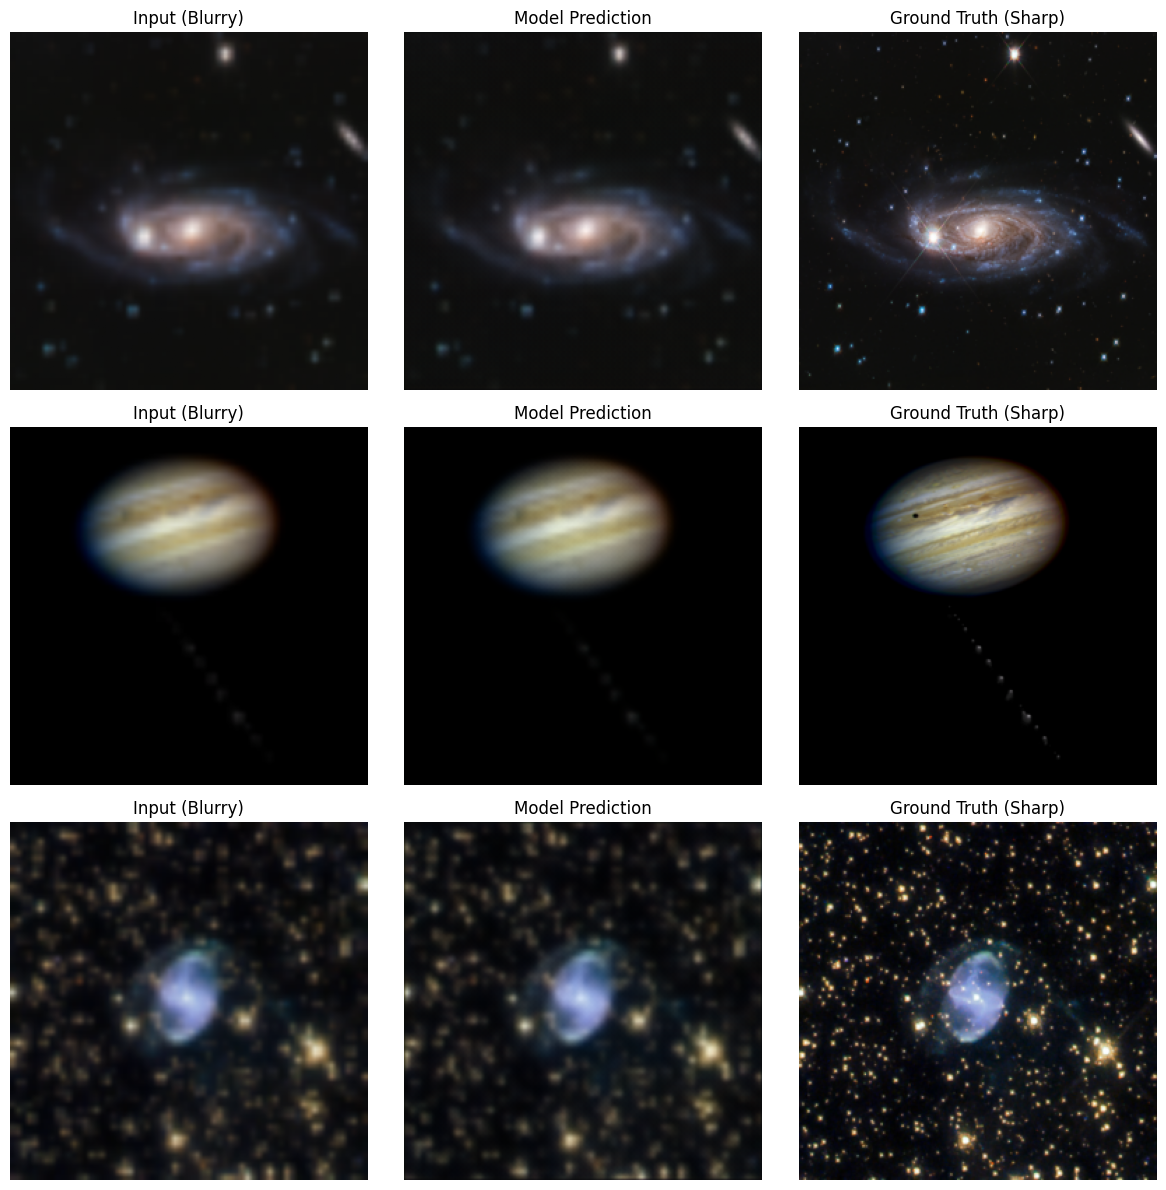

100%|██████████| 68/68 [12:42<00:00, 11.22s/it]


Epoch [6/50], Loss: 0.1318


100%|██████████| 68/68 [11:45<00:00, 10.38s/it]


Epoch [7/50], Loss: 0.1299


100%|██████████| 68/68 [08:55<00:00,  7.87s/it]


Epoch [8/50], Loss: 0.1283


100%|██████████| 68/68 [13:07<00:00, 11.58s/it]


Epoch [9/50], Loss: 0.1259


  0%|          | 0/68 [00:31<?, ?it/s]


KeyboardInterrupt: 

In [11]:
num_epochs = 50

Image.MAX_IMAGE_PIXELS = None

# Start Timer
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_losses = []
    for low_res, high_res in tqdm(train_loader):
        low_res, high_res = low_res.to(device), high_res.to(device)

        optimizer.zero_grad()
        outputs = model(low_res)
        loss = criterion(outputs, high_res)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # NEW: Visualize every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("Creating visualization...")
        visualize_sample(model, test_loader, device)

# End Timer
end_time = time.time()
training_duration = end_time - start_time
print(f"⏱️ Total Training Time: {training_duration/60:.2f} minutes")

## Model evalutation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043853395..0.9618918].


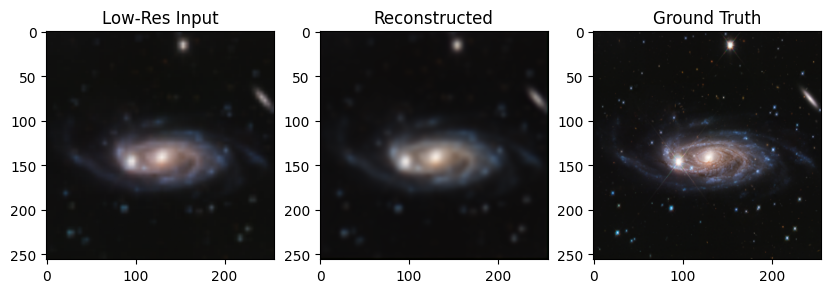

In [ ]:
model.eval()
with torch.no_grad():
    sample_lr, sample_hr = next(iter(test_loader))
    sample_lr, sample_hr = sample_lr.to(device), sample_hr.to(device)
    pred = model(sample_lr)

# Convert tensor → image
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("Low-Res Input")
plt.imshow(np.transpose(sample_lr[0].cpu().numpy(), (1,2,0)))
plt.subplot(1,3,2)
plt.title("Reconstructed")
plt.imshow(np.transpose(pred[0].cpu().numpy(), (1,2,0)))
plt.subplot(1,3,3)
plt.title("Ground Truth")
plt.imshow(np.transpose(sample_hr[0].cpu().numpy(), (1,2,0)))
plt.show()


In [ ]:
def evaluate_metrics_with_baseline(model, loader, device):
    model.eval()
    
    # Trackers for Model Performance
    model_psnr, model_ssim = 0.0, 0.0
    
    # Trackers for Baseline (Input) Performance
    base_psnr, base_ssim = 0.0, 0.0
    
    num_images = 0
    
    print("📊 Calculating Baseline vs. Model metrics...")
    
    with torch.no_grad():
        for low_res, high_res in tqdm(loader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            # 1. Generate Prediction
            outputs = model(low_res)
            
            # 2. Convert ALL images to Numpy (Input, Output, Target)
            # We clone low_res because we want to see how bad the input is
            inputs = low_res.cpu().clamp(0, 1).permute(0, 2, 3, 1).numpy()
            preds = outputs.cpu().clamp(0, 1).permute(0, 2, 3, 1).numpy()
            targets = high_res.cpu().clamp(0, 1).permute(0, 2, 3, 1).numpy()
            
            batch_size = preds.shape[0]
            for i in range(batch_size):
                inp = inputs[i] # The blurry input
                p = preds[i]    # The model output
                t = targets[i]  # The sharp target
                
                # --- BASELINE METRICS (Input vs Target) ---
                base_psnr += psnr_metric(t, inp, data_range=1.0)
                
                # Safe SSIM check for Baseline
                try:
                    val_b = ssim_metric(t, inp, data_range=1.0, channel_axis=2)
                except TypeError:
                    val_b = ssim_metric(t, inp, data_range=1.0, multichannel=True)
                base_ssim += val_b if not isinstance(val_b, tuple) else val_b[0]

                # --- MODEL METRICS (Output vs Target) ---
                model_psnr += psnr_metric(t, p, data_range=1.0)
                
                # Safe SSIM check for Model
                try:
                    val_m = ssim_metric(t, p, data_range=1.0, channel_axis=2)
                except TypeError:
                    val_m = ssim_metric(t, p, data_range=1.0, multichannel=True)
                model_ssim += val_m if not isinstance(val_m, tuple) else val_m[0]
                
                num_images += 1
                
    # Averages
    avg_base_psnr = base_psnr / num_images
    avg_base_ssim = base_ssim / num_images
    avg_model_psnr = model_psnr / num_images
    avg_model_ssim = model_ssim / num_images
    
    print("-" * 40)
    print(f"🌟 Final Evaluation over {num_images} images:")
    print(f"   📉 Baseline (Blurry):  PSNR: {avg_base_psnr:.2f} dB | SSIM: {avg_base_ssim:.4f}")
    print(f"   🚀 Model (Restored):   PSNR: {avg_model_psnr:.2f} dB | SSIM: {avg_model_ssim:.4f}")
    print("-" * 40)
    
    return avg_model_psnr, avg_model_ssim

evaluate_metrics_with_baseline(model, test_loader, device)

📊 Calculating Baseline vs. Model metrics...


100%|██████████| 18/18 [00:17<00:00,  1.04it/s]

----------------------------------------
🌟 Final Evaluation over 137 images:
   📉 Baseline (Blurry):  PSNR: 31.60 dB | SSIM: 0.8509
   🚀 Model (Restored):   PSNR: 29.69 dB | SSIM: 0.8280
----------------------------------------


(29.69321843137758, 0.8280157096629596)